In [461]:
import psycopg2
import random
import names
import uuid
import datetime
import re
import matplotlib.pyplot as plt

In [462]:
def index_tester(what_index, Query, Drop):
    try:
        con = psycopg2.connect(
                host = "127.0.0.11",
                database="ZSBD_p1",
                user = "inzdanych123",
                password = "inzdanych123")

        cur = con.cursor()

        cur.execute(Drop)

        if what_index != None:
            cur.execute(what_index)

        cur.execute(Query)
        query_output = cur.fetchall()
        
        if query_output != None:
            return query_output

    except (Exception, psycopg2.Error) as error:
        return error
        # print("Error while fetching data from PostgreSQL", error)

    finally:
        # closing database connection.
        if con:
            cur.close()
            con.close()

In [463]:
Q = 'EXPLAIN ANALYSE SELECT * FROM ai_med.objawy WHERE bol_glowy is TRUE;'
D = 'DROP INDEX IF EXISTS ai_med.data_bol;'
index_query = 'CREATE INDEX data_bol on ai_med.objawy using %s (bol_glowy);'

In [464]:
Q = 'EXPLAIN ANALYSE SELECT * FROM ai_med."leczenie_w_kierunku_kod_ICD_10"' + " WHERE data_zakonczenia_leczenia_i10 >= '2021-02-01' AND data_zakonczenia_leczenia_i10 <= '2021-02-28';"
index_name_query = 'data_icd_10'

D = 'DROP INDEX IF EXISTS ai_med.%s;' %(index_name_query)
index_query = 'CREATE INDEX '
index_query += index_name_query
index_query += ' on ai_med."leczenie_w_kierunku_kod_ICD_10" using %s (data_zakonczenia_leczenia_i10);' 

In [465]:
index_list = [None, 'btree', 'HASH', 'gist', 'spgist', 'gin', 'BRIN']
seq_scan_list = []
other__list = {}


seq_scan_dict_floats_planning = {}
seq_scan_dict_floats_executing = {}
planning_time = []
execution_time = []
planning_time_non_seq = []
execution_time_non_seq = []

for index in index_list:
    if index == None:
        mes = index_tester(None, Q, D)
    else:
        mes = index_tester(index_query %(index), Q, D)

    if type(mes) == list:
        if str(mes[0]).split('on')[0] == "('Seq Scan ":
            
            planning_time.append(float(re.findall(r'[\d]*[.][\d]+', str(mes[-2:][0]))[0]))
            execution_time.append(float(re.findall(r'[\d]*[.][\d]+', str(mes[-2:][1]))[0]))

            seq_scan_dict_floats_planning['seq scan'] = planning_time
            seq_scan_dict_floats_executing['seq scan'] = execution_time 
        else:
            planning_time_non_seq.append(float(re.findall(r'[\d]*[.][\d]+', str(mes[-2:][0]))[0]))
            execution_time_non_seq.append(float(re.findall(r'[\d]*[.][\d]+', str(mes[-2:][1]))[0]))

            seq_scan_dict_floats_planning[str(mes[0]).split('on')[0].strip('(')] = planning_time_non_seq[0]
            seq_scan_dict_floats_executing[str(mes[0]).split('on')[0].strip('(')] = execution_time_non_seq[0]
    else:
        print(index, ' zwrocil blad:', '\n', mes)

gist  zwrocil blad: 
 data type date has no default operator class for access method "gist"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

spgist  zwrocil blad: 
 data type date has no default operator class for access method "spgist"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.

gin  zwrocil blad: 
 data type date has no default operator class for access method "gin"
HINT:  You must specify an operator class for the index or define a default operator class for the data type.



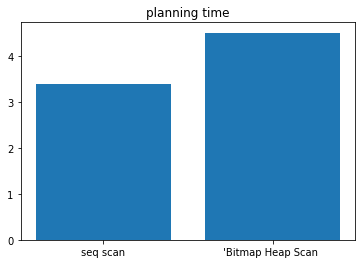

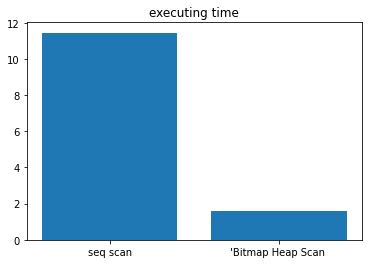

In [466]:
try:
    seq_scan_dict_floats_executing['seq scan'] = seq_scan_dict_floats_executing['seq scan'][0]
    seq_scan_dict_floats_planning['seq scan'] = seq_scan_dict_floats_planning['seq scan'][0]
except(TypeError):
    pass

names = list(seq_scan_dict_floats_planning.keys())
values = list(seq_scan_dict_floats_planning.values())
plt.bar(range(len(seq_scan_dict_floats_planning)), values, tick_label=names)
plt.title('planning time')
plt.show()

names = list(seq_scan_dict_floats_executing.keys())
values = list(seq_scan_dict_floats_executing.values())
plt.bar(range(len(seq_scan_dict_floats_executing)), values, tick_label=names)
plt.title('executing time')
plt.show()

In [467]:
Q = 'EXPLAIN ANALYSE SELECT * FROM ai_med."leczenie_w_kierunku_kod_ICD_10"' + " WHERE data_zakonczenia_leczenia_i10 >= '2021-02-01' AND data_zakonczenia_leczenia_i10 <= '2021-02-28';"
D = 'DROP INDEX IF EXISTS ai_med.data_icd_10;'

In [468]:
index_tester(None, Q, D)

[('Seq Scan on "leczenie_w_kierunku_kod_ICD_10"  (cost=0.00..1118.00 rows=1888 width=28) (actual time=0.056..14.167 rows=1889 loops=1)',),
 ("  Filter: ((data_zakonczenia_leczenia_i10 >= '2021-02-01'::date) AND (data_zakonczenia_leczenia_i10 <= '2021-02-28'::date))",),
 ('  Rows Removed by Filter: 48111',),
 ('Planning Time: 4.342 ms',),
 ('Execution Time: 14.368 ms',)]

In [469]:
index_tester('CREATE INDEX data_icd_10 on ai_med."leczenie_w_kierunku_kod_ICD_10"(data_zakonczenia_leczenia_i10)', Q, D)

[('Bitmap Heap Scan on "leczenie_w_kierunku_kod_ICD_10"  (cost=27.64..423.96 rows=1888 width=28) (actual time=0.567..1.723 rows=1889 loops=1)',),
 ("  Recheck Cond: ((data_zakonczenia_leczenia_i10 >= '2021-02-01'::date) AND (data_zakonczenia_leczenia_i10 <= '2021-02-28'::date))",),
 ('  Heap Blocks: exact=364',),
 ('  ->  Bitmap Index Scan on data_icd_10  (cost=0.00..27.17 rows=1888 width=0) (actual time=0.479..0.480 rows=1889 loops=1)',),
 ("        Index Cond: ((data_zakonczenia_leczenia_i10 >= '2021-02-01'::date) AND (data_zakonczenia_leczenia_i10 <= '2021-02-28'::date))",),
 ('Planning Time: 6.524 ms',),
 ('Execution Time: 1.966 ms',)]

In [470]:
index_tester('CREATE INDEX data_icd_10 on ai_med."leczenie_w_kierunku_kod_ICD_10" using brin (data_zakonczenia_leczenia_i10)', Q, D)

[('Seq Scan on "leczenie_w_kierunku_kod_ICD_10"  (cost=0.00..1118.00 rows=1888 width=28) (actual time=0.037..10.945 rows=1889 loops=1)',),
 ("  Filter: ((data_zakonczenia_leczenia_i10 >= '2021-02-01'::date) AND (data_zakonczenia_leczenia_i10 <= '2021-02-28'::date))",),
 ('  Rows Removed by Filter: 48111',),
 ('Planning Time: 5.969 ms',),
 ('Execution Time: 11.130 ms',)]

In [471]:
#Q = 'EXPLAIN ANALYSE SELECT * FROM ai_med.objawy WHERE bol_glowy = TRUE;'
Q = 'EXPLAIN ANALYSE SELECT * FROM ai_med.objawy WHERE bol_glowy is TRUE;'
D = 'DROP INDEX IF EXISTS ai_med.data_bol;'

In [472]:
index_tester(None, Q, D)

[('Seq Scan on objawy  (cost=0.00..771.00 rows=25175 width=10) (actual time=0.056..50.751 rows=25045 loops=1)',),
 ('  Filter: (bol_glowy IS TRUE)',),
 ('  Rows Removed by Filter: 24955',),
 ('Planning Time: 12.088 ms',),
 ('Execution Time: 52.881 ms',)]

In [473]:
index_tester('CREATE INDEX data_bol on ai_med.objawy(bol_glowy);', Q, D)

[('Seq Scan on objawy  (cost=0.00..771.00 rows=25175 width=10) (actual time=0.031..10.615 rows=25045 loops=1)',),
 ('  Filter: (bol_glowy IS TRUE)',),
 ('  Rows Removed by Filter: 24955',),
 ('Planning Time: 6.442 ms',),
 ('Execution Time: 12.355 ms',)]

In [474]:
index_tester('CREATE INDEX data_bol on ai_med.objawy using hash (bol_glowy);', Q, D)

[('Seq Scan on objawy  (cost=0.00..771.00 rows=25175 width=10) (actual time=0.047..9.159 rows=25045 loops=1)',),
 ('  Filter: (bol_glowy IS TRUE)',),
 ('  Rows Removed by Filter: 24955',),
 ('Planning Time: 5.109 ms',),
 ('Execution Time: 10.891 ms',)]